### dataset used here: kaggle.com/datasets/markkostantine/potato-leaf-disease-original-augmented/versions/1

### CELL 1: Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import tensorflow as tf
from pathlib import Path
from PIL import Image
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, 
                            precision_recall_curve, average_precision_score,
                            roc_curve, auc)
from skimage.feature import graycomatrix, graycoprops
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')
sns.set(font_scale=1.4)

2025-12-31 09:12:19.331290: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767172339.549209      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767172339.613015      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

### CELL 2: Parameters

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 55
SEED = 58
DATASET_PATH = "/kaggle/input/potato-leaf-disease-original-augmented/Dataset"


### CELL 3: Load Dataset


In [3]:
dataset = image_dataset_from_directory(
    DATASET_PATH,
    seed=SEED,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)
class_names = dataset.class_names
print("Classes:", class_names)


Found 5236 files belonging to 7 classes.


I0000 00:00:1767172358.462459      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1767172358.463123      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Classes: ['Bacteria', 'Fungi', 'Healthy', 'Nematode', 'Pest', 'Phytopthora', 'Virus']


### CELL 4: Detailed Image Info DataFrame

In [4]:

print("Extracting detailed image information...")
image_info = []
folders = [d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))]

for cls in tqdm(folders, desc="Processing classes"):
    folder_path = Path(DATASET_PATH) / cls
    for img_path in list(folder_path.glob("*"))[:500]:  # Limit for performance
        try:
            img = Image.open(img_path).convert("RGB")
            w, h = img.size
            img_np = np.array(img)
            
            # Calculate GLCM texture features
            gray = np.array(img.convert('L'))
            gray_resized = np.resize(gray, (min(gray.shape[0], 100), min(gray.shape[1], 100)))
            glcm = graycomatrix(gray_resized, [1], [0], levels=256, symmetric=True, normed=True)
            
            image_info.append({
                "class": cls,
                "width": w,
                "height": h,
                "aspect_ratio": w / h,
                "mean_R": img_np[:,:,0].mean(),
                "mean_G": img_np[:,:,1].mean(),
                "mean_B": img_np[:,:,2].mean(),
                "std_R": img_np[:,:,0].std(),
                "std_G": img_np[:,:,1].std(),
                "std_B": img_np[:,:,2].std(),
                "contrast": graycoprops(glcm, 'contrast')[0, 0],
                "dissimilarity": graycoprops(glcm, 'dissimilarity')[0, 0],
                "homogeneity": graycoprops(glcm, 'homogeneity')[0, 0],
                "energy": graycoprops(glcm, 'energy')[0, 0],
                "correlation": graycoprops(glcm, 'correlation')[0, 0]
            })
        except Exception as e:
            continue

df_info = pd.DataFrame(image_info)
print(f"\nDataset Info Shape: {df_info.shape}")
print("\nFirst few rows:")
print(df_info.head())
print("\nStatistical Summary:")
print(df_info.describe())


Extracting detailed image information...


Processing classes: 100%|██████████| 7/7 [03:59<00:00, 34.20s/it]


Dataset Info Shape: (3500, 15)

First few rows:
      class  width  height  aspect_ratio      mean_R      mean_G      mean_B  \
0  Nematode   1500    1500           1.0  114.640941  131.221694   67.189256   
1  Nematode   1500    1500           1.0  108.963570  111.420648   79.601360   
2  Nematode   1500    1500           1.0  143.210527  149.056861  120.254445   
3  Nematode   1500    1500           1.0  143.955048  136.813873   52.824290   
4  Nematode   1500    1500           1.0  128.375367  122.679310   70.376476   

       std_R      std_G      std_B   contrast  dissimilarity  homogeneity  \
0  57.440126  58.925707  35.527692  65.705253       4.513535     0.361668   
1  62.756625  60.519209  51.606094   6.823030       1.652727     0.503418   
2  57.904640  53.729664  73.696586   2.627778       0.849798     0.698468   
3  49.037340  40.194920  53.645233   5.283838       1.527273     0.520480   
4  66.587393  50.578301  39.183979   3.475758       1.183636     0.576126   

     en

### CELL 5: Class Distribution & Imbalance Analysis


Class Distribution:
         Class  Count  Percentage  Imbalance_Ratio
0     Bacteria    748       14.29              1.0
1        Fungi    748       14.29              1.0
2      Healthy    748       14.29              1.0
3     Nematode    748       14.29              1.0
4         Pest    748       14.29              1.0
5  Phytopthora    748       14.29              1.0
6        Virus    748       14.29              1.0


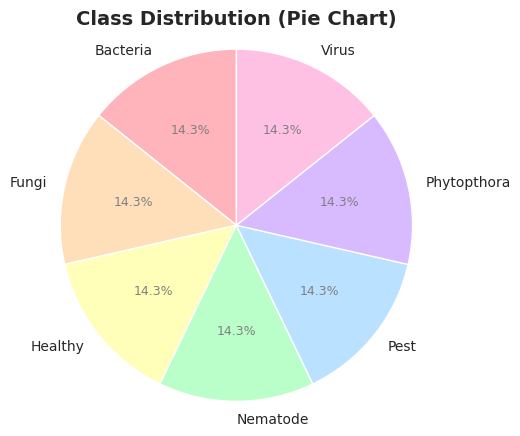

In [7]:

def get_all_labels(ds):
    labels = []
    for _, labels_batch in ds:
        labels.extend(labels_batch.numpy())
    return labels

labels = get_all_labels(dataset)
class_counts = {class_name: 0 for class_name in class_names}
for label in labels:
    class_counts[class_names[label]] += 1

# Class Imbalance Analysis
df_class = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])
df_class['Percentage'] = (df_class['Count'] / df_class['Count'].sum() * 100).round(2)
df_class['Imbalance_Ratio'] = (df_class['Count'] / df_class['Count'].min()).round(2)

print("\nClass Distribution:")
print(df_class)

soft_colors = ['#FFB3BA', '#FFDFBA', '#FFFFBA', '#BAFFC9', '#BAE1FF', '#D7BAFF', '#FFC1E3']

plt.figure(figsize=(5, 5))
wedges, texts, autotexts = plt.pie(
    df_class['Count'],
    labels=df_class['Class'],
    autopct='%1.1f%%',
    startangle=90,
    colors=soft_colors[:len(df_class)],
    textprops={'fontsize': 10}
)

for autotext in autotexts:
    autotext.set_color('gray')
    autotext.set_fontsize(9)

plt.title('Class Distribution (Pie Chart)', fontsize=14, fontweight='bold')
plt.axis('equal')  # Make pie chart circular
plt.show()


### CELL 6: RGB Color Histogram Analysis


Generating RGB Color Histograms...


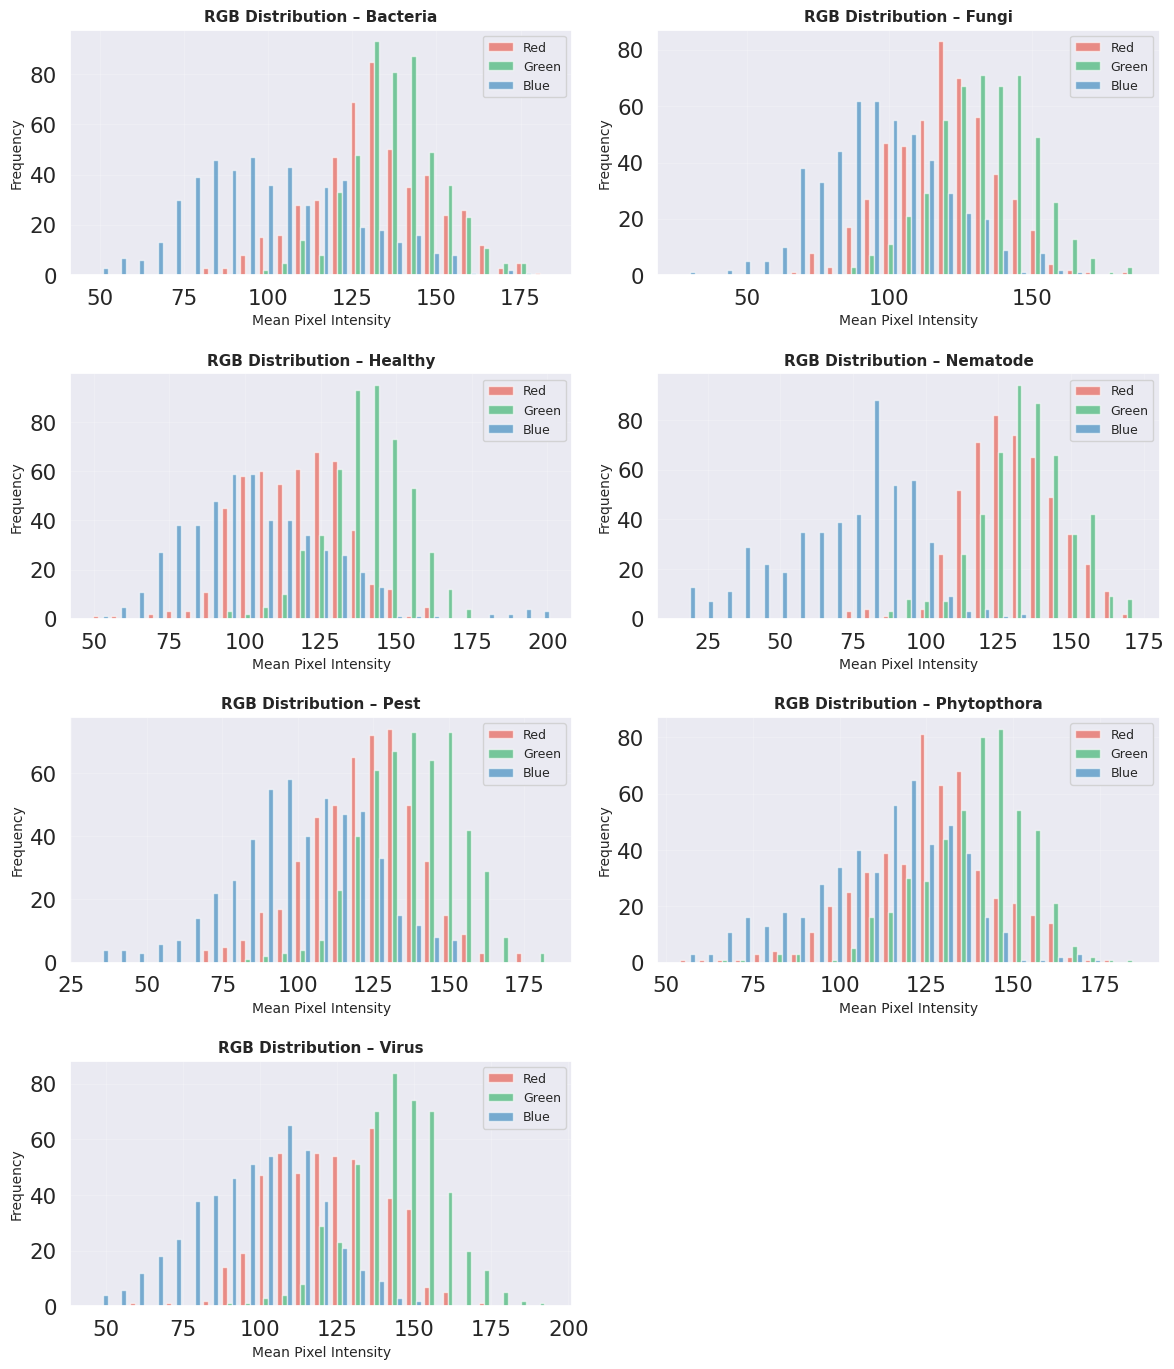

In [8]:
import math

print("\nGenerating RGB Color Histograms...")

n_classes = len(class_names)
n_cols = 2
n_rows = math.ceil(n_classes / n_cols)

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(12, 3.5 * n_rows)
)
axes = axes.flatten()
colors = ["#e74c3c", "#27ae60", "#2980b9"] 

for idx, cls in enumerate(class_names):
    cls_data = df_info[df_info['class'] == cls]

    axes[idx].hist(
        [cls_data['mean_R'], cls_data['mean_G'], cls_data['mean_B']],
        bins=25,
        label=['Red', 'Green', 'Blue'],
        alpha=0.6,
        color=colors
    )
    axes[idx].set_xlabel('Mean Pixel Intensity', fontsize=10)
    axes[idx].set_ylabel('Frequency', fontsize=10)
    axes[idx].set_title(f'RGB Distribution – {cls}', fontweight='bold', fontsize=11)
    axes[idx].legend(fontsize=9)
    axes[idx].grid(alpha=0.2)

for i in range(idx + 1, len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.show()


### CELL 7: Texture Features Heatmap

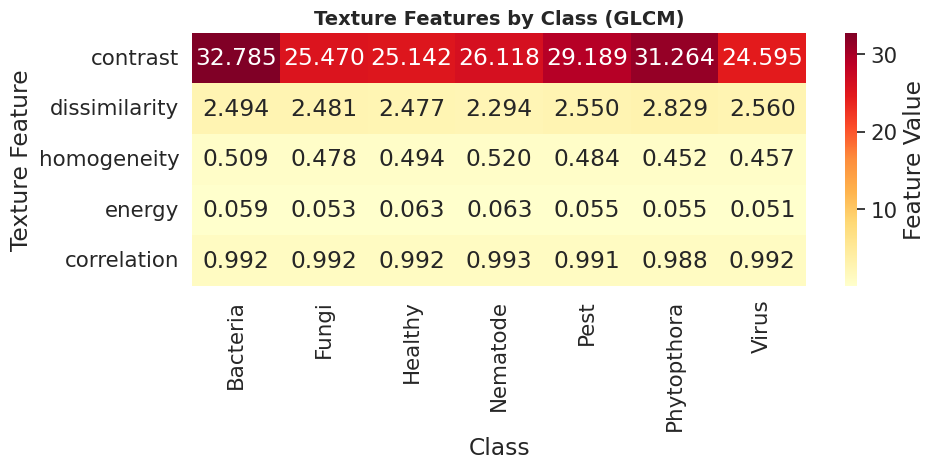

In [10]:

texture_features = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
texture_df = df_info.groupby('class')[texture_features].mean()

plt.figure(figsize=(10, 5))
sns.heatmap(texture_df.T, annot=True, fmt='.3f', cmap='YlOrRd', cbar_kws={'label': 'Feature Value'})
plt.title('Texture Features by Class (GLCM)', fontweight='bold', fontsize=14)
plt.xlabel('Class')
plt.ylabel('Texture Feature')
plt.tight_layout()
plt.show()

### CELL 8: Principal Component Analysis (PCA)


Performing PCA on image features...


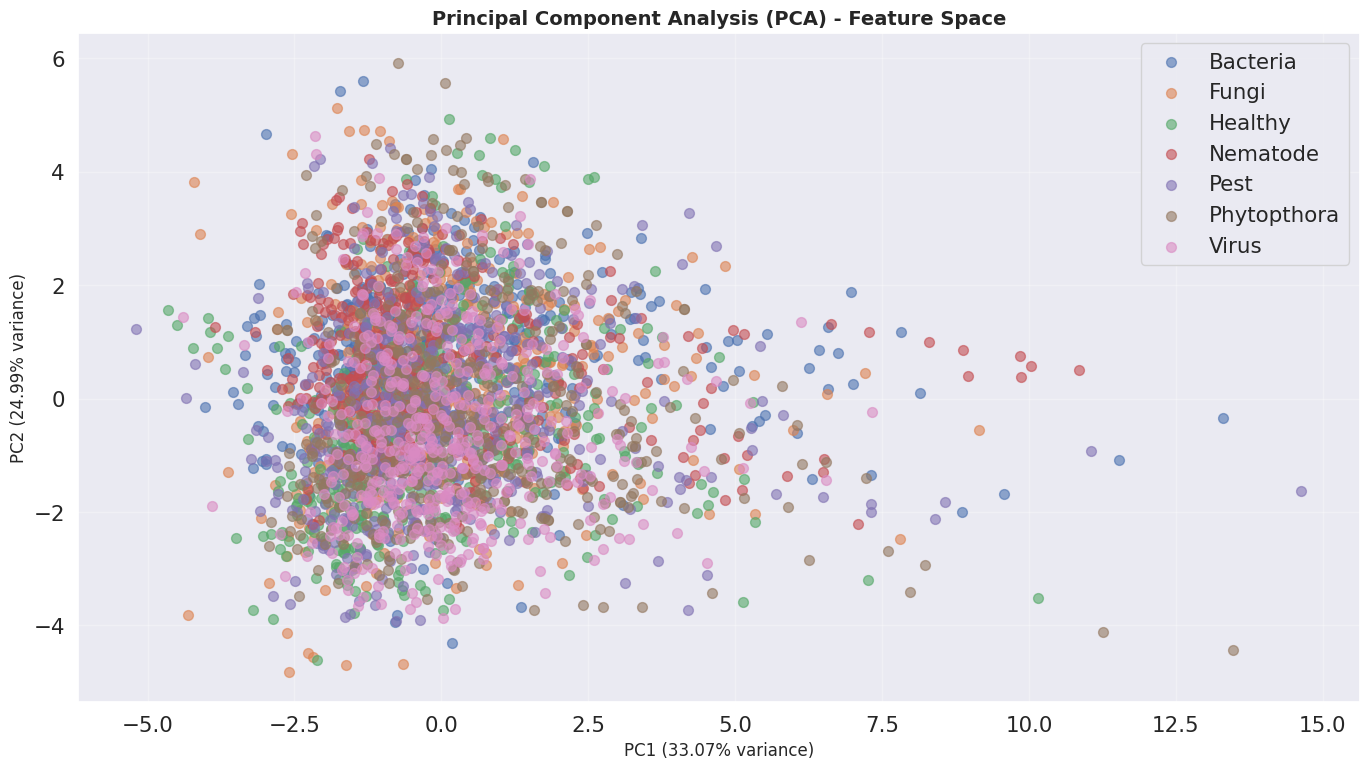

Explained variance ratio: [0.33073696 0.24994834]
Total variance explained: 58.07%


In [11]:

print("\nPerforming PCA on image features...")
feature_cols = ['mean_R', 'mean_G', 'mean_B', 'std_R', 'std_G', 'std_B', 
                'contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
X_features = df_info[feature_cols].values
y_classes = df_info['class'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['class'] = y_classes

plt.figure(figsize=(14, 8))
for cls in class_names:
    cls_data = pca_df[pca_df['class'] == cls]
    plt.scatter(cls_data['PC1'], cls_data['PC2'], label=cls, alpha=0.6, s=50)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance)', fontsize=12)
plt.title('Principal Component Analysis (PCA) - Feature Space', fontweight='bold', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_)*100:.2f}%")


### CELL 9: Inter-Class Feature Similarity Matrix


Calculating inter-class feature similarity...


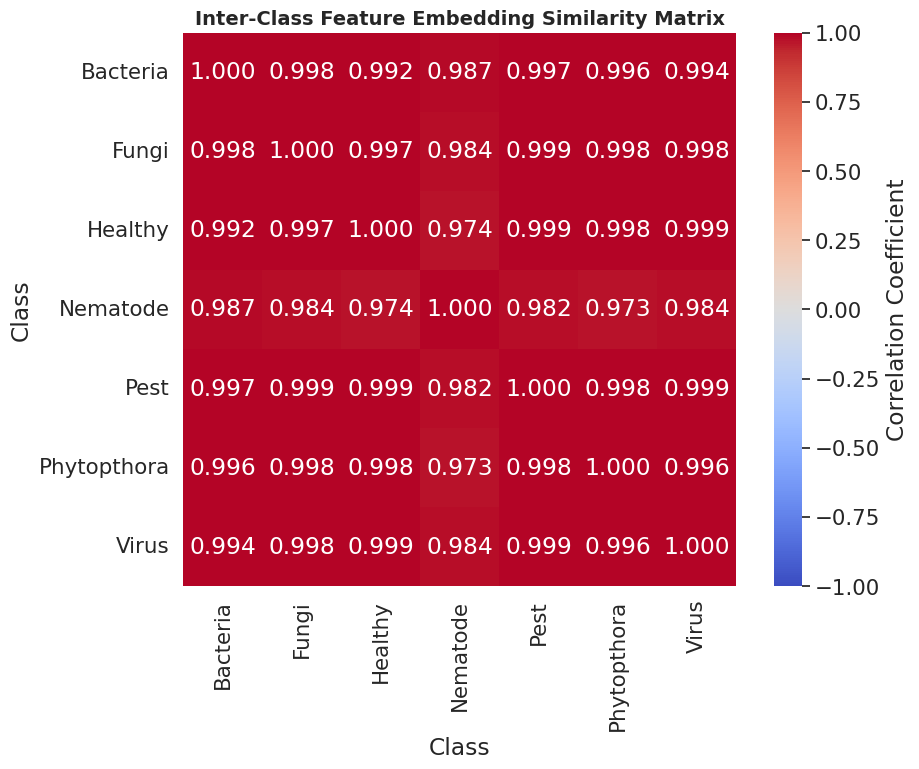

In [16]:

print("\nCalculating inter-class feature similarity...")
class_features = df_info.groupby('class')[feature_cols].mean()
correlation_matrix = class_features.T.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, vmin=-1, vmax=1, square=True, 
            cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Inter-Class Feature Embedding Similarity Matrix', fontweight='bold', fontsize=14)
plt.xlabel('Class')
plt.ylabel('Class')
plt.tight_layout()
plt.show()

### CELL 10: Visualize Sample Images

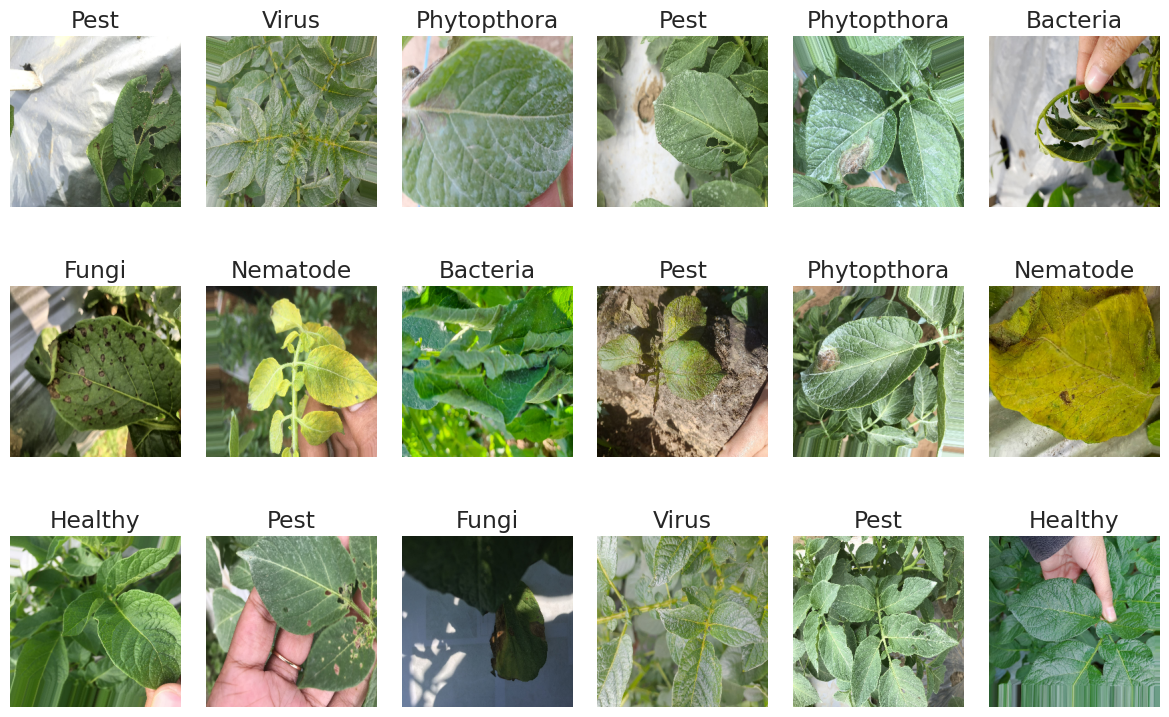

In [17]:
plt.figure(figsize=(12, 8))
for images, labels in dataset.take(1):
    for i in range(18):
        ax = plt.subplot(3, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.tight_layout()
plt.show()

### CELL 11: Split Dataset 

In [18]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=SEED)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
print(f"Train batches: {len(train_ds)}, Val batches: {len(val_ds)}, Test batches: {len(test_ds)}")


Train batches: 131, Val batches: 16, Test batches: 17


### CELL 12: Optimize Performance 

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### CELL 13: Build Model

In [20]:
def create_efficientnet_model(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), num_classes=7):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dense(256, activation='relu'),
        Dropout(0.4),
        BatchNormalization(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

model = create_efficientnet_model(num_classes=len(class_names))
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 8, 8, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,417,450 (16.85 MB)

 Trainable params: 364,807 (1.39 MB)

 Non-trainable params: 4,052,643 (15.46 MB)

### CELL 14: Train Model 

In [21]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/55


I0000 00:00:1767173860.487327     115 service.cc:148] XLA service 0x7f7b48002180 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767173860.489606     115 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1767173860.489627     115 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1767173862.458131     115 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1767173865.174542     115 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1767173865.357439     115 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


  3/131 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.0955 - loss: 2.8268   

I0000 00:00:1767173873.893090     115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/131 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2283 - loss: 2.2297

E0000 00:00:1767173881.801707     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1767173881.967837     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


131/131 ━━━━━━━━━━━━━━━━━━━━ 85s 322ms/step - accuracy: 0.2330 - loss: 2.2132 - val_accuracy: 0.6309 - val_loss: 1.3597
Epoch 2/55
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.5118 - loss: 1.3249 - val_accuracy: 0.7109 - val_loss: 0.9496
Epoch 3/55
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.5983 - loss: 1.0840 - val_accuracy: 0.7539 - val_loss: 0.7357
Epoch 4/55
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.6515 - loss: 0.9371 - val_accuracy: 0.7871 - val_loss: 0.6128
Epoch 5/55
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.6894 - loss: 0.8409 - val_accuracy: 0.8184 - val_loss: 0.5476
Epoch 6/55
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.7220 - loss: 0.7784 - val_accuracy: 0.8340 - val_loss: 0.4955
Epoch 7/55
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.7439 - loss: 0.7174 - val_accuracy: 0.8613 - val_loss: 0.4558
Epoch 8/55
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.7540 - loss: 0.6651 - val_accuracy: 0.8

### CELL 15: Plot Training Curves 

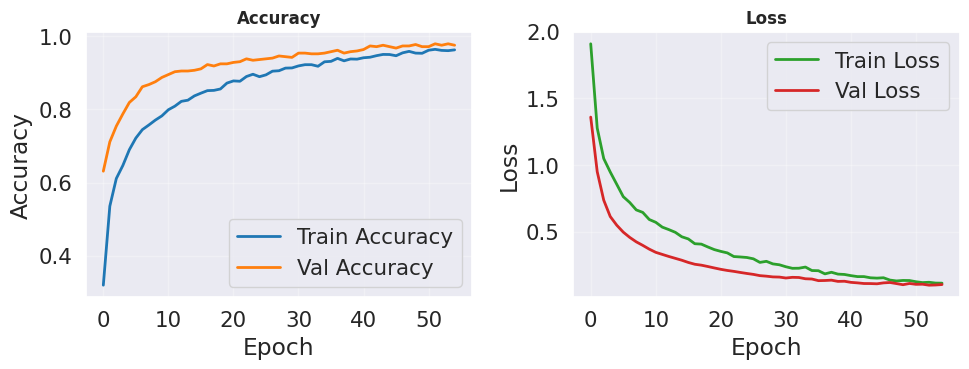

In [22]:
import matplotlib.pyplot as plt

def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Accuracy', color='#1f77b4', linewidth=2)
    plt.plot(val_acc, label='Val Accuracy', color='#ff7f0e', linewidth=2)
    plt.legend()
    plt.title('Accuracy', fontsize=12, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss', color='#2ca02c', linewidth=2)
    plt.plot(val_loss, label='Val Loss', color='#d62728', linewidth=2)
    plt.legend()
    plt.title('Loss', fontsize=12, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training(history)


### CELL 16: Evaluate Model

In [23]:

test_loss, test_acc = model.evaluate(test_ds)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - accuracy: 0.9709 - loss: 0.1061

Test Loss: 0.1054
Test Accuracy: 0.9688


### CELL 17: Get Predictions for Advanced Metrics

In [24]:

y_true = []
y_pred = []
y_pred_proba = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_pred_proba.extend(preds)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

### CELL 18: Classification Report 

In [25]:
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:

              precision    recall  f1-score   support

    Bacteria       0.99      1.00      0.99        87
       Fungi       0.93      0.95      0.94        73
     Healthy       0.97      0.99      0.98        77
    Nematode       0.96      1.00      0.98        80
        Pest       0.96      0.91      0.93        76
 Phytopthora       0.99      0.97      0.98        75
       Virus       0.97      0.96      0.97        76

    accuracy                           0.97       544
   macro avg       0.97      0.97      0.97       544
weighted avg       0.97      0.97      0.97       544



### CELL 19: Confusion Matrix

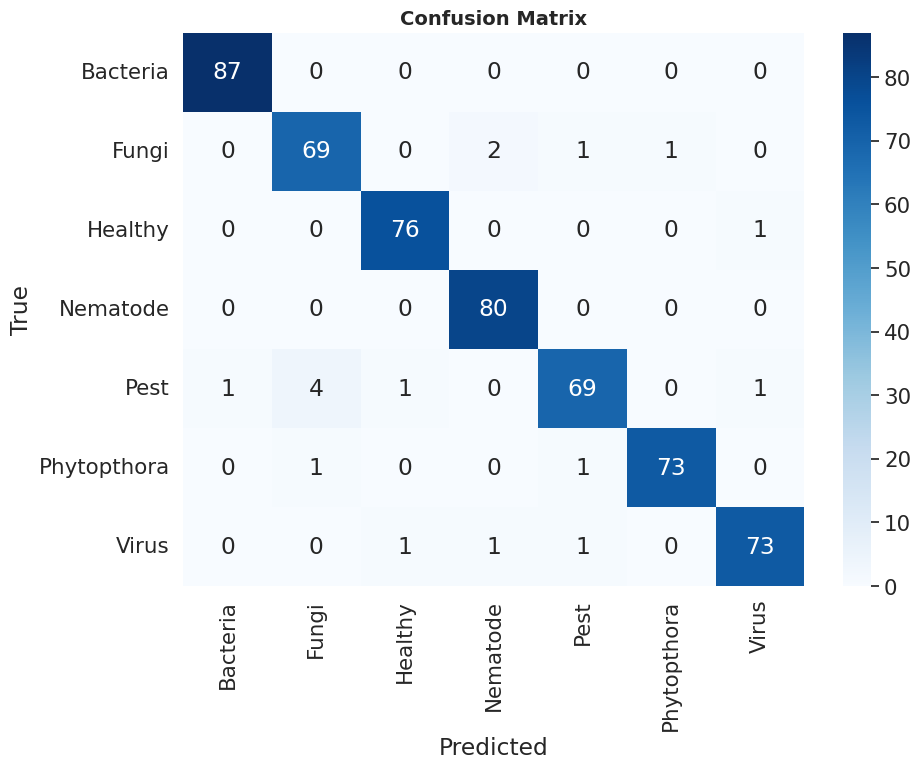

In [26]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix", fontweight='bold', fontsize=14)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

### CELL 20: Precision-Recall Curves 

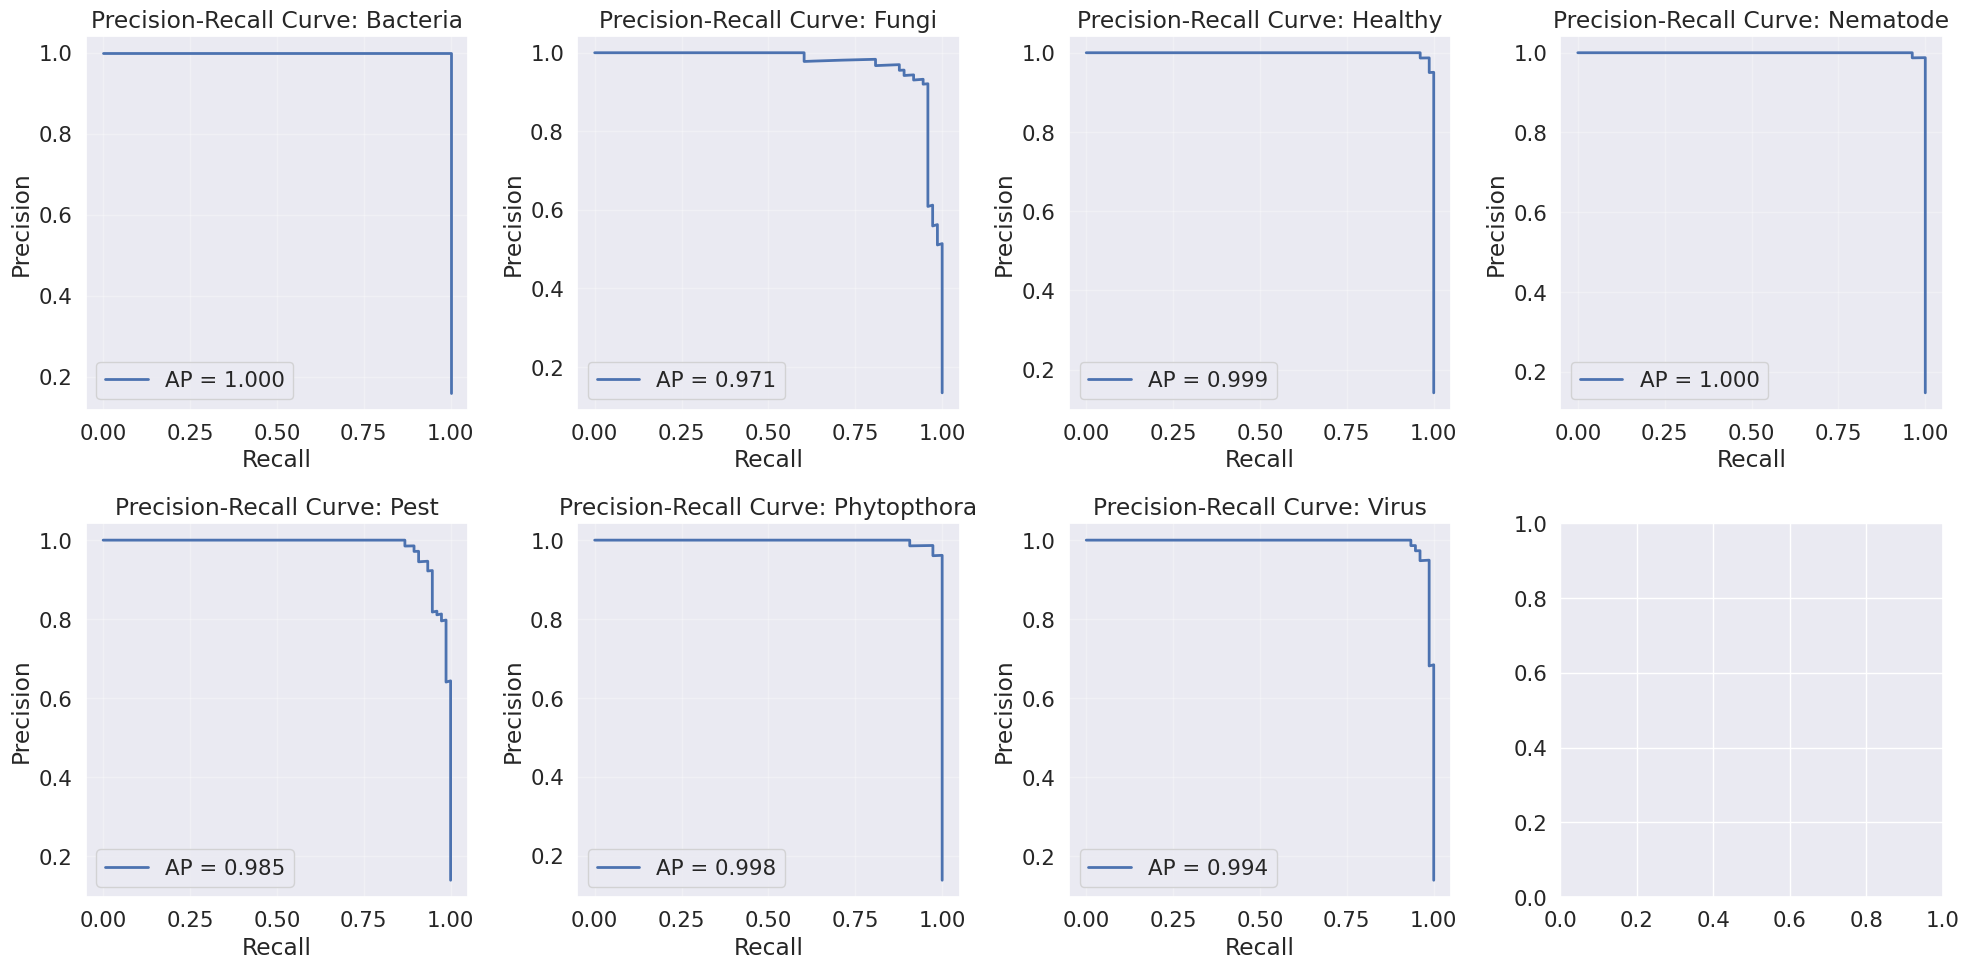

In [27]:
from sklearn.preprocessing import label_binarize
y_true_bin = label_binarize(y_true, classes=range(len(class_names)))

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, cls in enumerate(class_names):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_proba[:, i])
    avg_precision = average_precision_score(y_true_bin[:, i], y_pred_proba[:, i])
    
    axes[i].plot(recall, precision, linewidth=2, label=f'AP = {avg_precision:.3f}')
    axes[i].set_xlabel('Recall')
    axes[i].set_ylabel('Precision')
    axes[i].set_title(f'Precision-Recall Curve: {cls}')
    axes[i].legend()
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### CELL 21: ROC Curves 

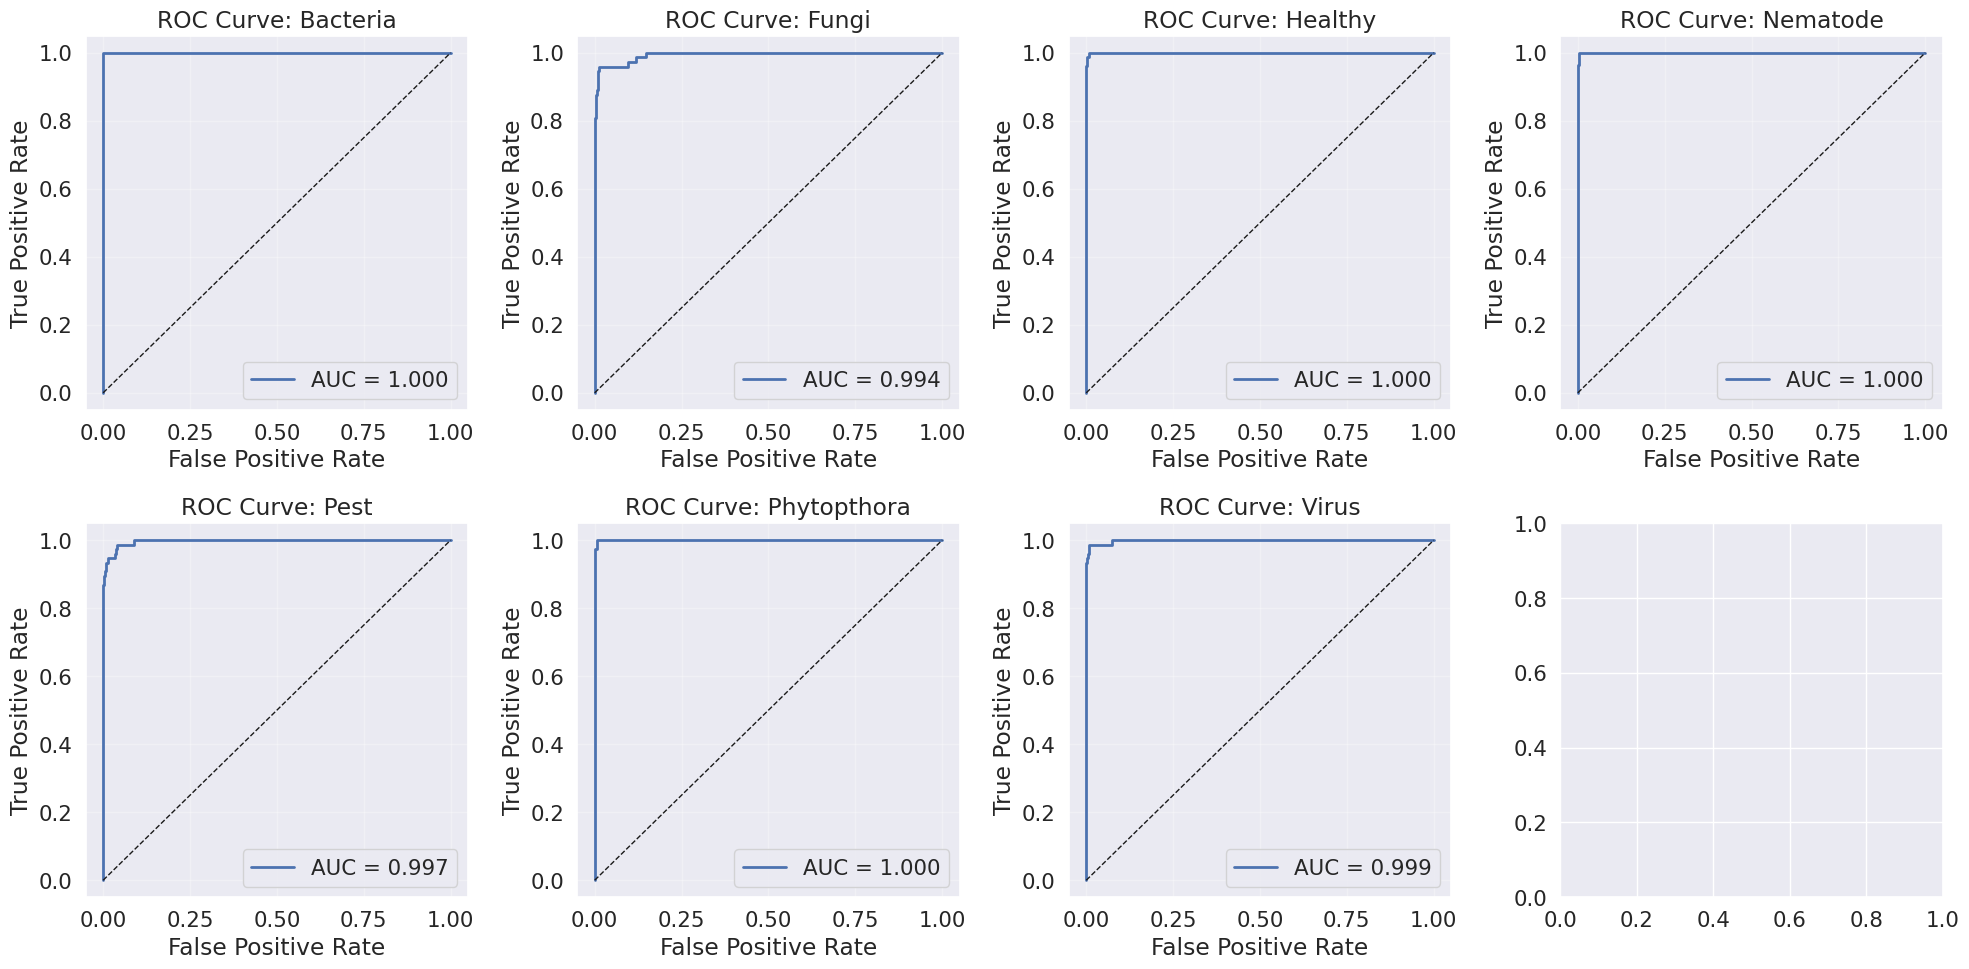

In [28]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, cls in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    
    axes[i].plot(fpr, tpr, linewidth=2, label=f'AUC = {roc_auc:.3f}')
    axes[i].plot([0, 1], [0, 1], 'k--', linewidth=1)
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    axes[i].set_title(f'ROC Curve: {cls}')
    axes[i].legend()
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [29]:
import os
import sys
import contextlib

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0=all, 1=warning, 2=error, 3=fatal

import tensorflow as tf

tf.get_logger().setLevel('ERROR')

@contextlib.contextmanager
def suppress_stdout_stderr():
    with open(os.devnull, 'w') as devnull:
        old_stdout, old_stderr = sys.stdout, sys.stderr
        sys.stdout, sys.stderr = devnull, devnull
        try:
            yield
        finally:
            sys.stdout, sys.stderr = old_stdout, old_stderr

model.save("efficientnet_potato_leaf_model.keras")
print("Model saved in Keras format")

with suppress_stdout_stderr():
    model.export("efficientnet_potato_leaf_model")

print("Model exported as SavedModel")

Model saved in Keras format
Model exported as SavedModel


### CELL 23: load model


In [30]:
# Load the model
model_path = '/kaggle/working/efficientnet_potato_leaf_model.keras'
loaded_model = load_model(model_path)
print("\nModel loaded successfully!")

def predict_image(model, img_path, class_names):

    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Create batch dimension
    
    predictions = model.predict(img_array, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    predicted_class = class_names[predicted_class_idx]
    confidence = predictions[0][predicted_class_idx]
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_class}\nConfidence: {confidence:.2%}', 
              fontweight='bold', fontsize=12)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.barh(class_names, predictions[0], color='skyblue', edgecolor='black')
    plt.xlabel('Confidence Score')
    plt.title('Class Probabilities', fontweight='bold', fontsize=12)
    plt.xlim(0, 1)
    
    plt.barh(predicted_class, confidence, color='green', edgecolor='black')
    
    plt.tight_layout()
    plt.show()
    
    return predicted_class, confidence, predictions[0]


Model loaded successfully!


### CELL 24: test using loaded Model


Testing inference on: /kaggle/input/potato-leaf-disease-original-augmented/Dataset/Nematode/IMG_8333_aug9.jpg


E0000 00:00:1767174272.644957     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1767174272.777872     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


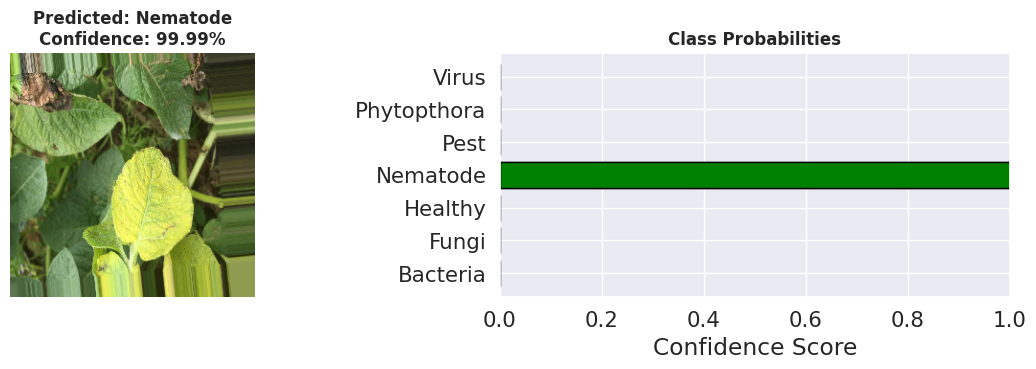


Predicted Class: Nematode
Confidence: 99.99%

All Class Probabilities:
  Bacteria: 0.0000
  Fungi: 0.0000
  Healthy: 0.0000
  Nematode: 0.9999
  Pest: 0.0000
  Phytopthora: 0.0001
  Virus: 0.0000
Complete! Model training, evaluation, and inference pipeline finished successfully.


In [31]:
test_image_path = None
for cls in os.listdir(DATASET_PATH):
    cls_path = os.path.join(DATASET_PATH, cls)
    if os.path.isdir(cls_path):
        images = [f for f in os.listdir(cls_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
        if images:
            test_image_path = os.path.join(cls_path, images[0])
            break

if test_image_path:
    print(f"\nTesting inference on: {test_image_path}")
    predicted_class, confidence, all_probs = predict_image(loaded_model, test_image_path, class_names)
    
    print(f"\nPredicted Class: {predicted_class}")
    print(f"Confidence: {confidence:.2%}")
    print("\nAll Class Probabilities:")
    for cls, prob in zip(class_names, all_probs):
        print(f"  {cls}: {prob:.4f}")
else:
    print("No test image found in dataset")

print("Complete! Model training, evaluation, and inference pipeline finished successfully.")


### CELL 25: Final report

In [33]:
report_file = "potato_leaf_disease_report.txt"

with open(report_file, "w", encoding="utf-8") as f:
    print("=" * 80, file=f)
    print("POTATO LEAF DISEASE CLASSIFICATION - FINAL REPORT", file=f)
    print("=" * 80, file=f)
    
    print("\n📊 MODEL PERFORMANCE SUMMARY", file=f)
    print("-" * 40, file=f)
    print(f"📈 Final Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)", file=f)
    print(f"📉 Final Test Loss: {test_loss:.4f}", file=f)
    print(f"🎯 Number of Classes: {len(class_names)}", file=f)
    print(f"📁 Classes Identified: {', '.join(class_names)}", file=f)
    print(f"🖼️ Image Size: {IMAGE_SIZE}x{IMAGE_SIZE} pixels", file=f)
    print(f"🧠 Model Architecture: EfficientNetB0 (Transfer Learning)", file=f)
    print(f"⏱️ Training Epochs: {EPOCHS}", file=f)
    print(f"📦 Batch Size: {BATCH_SIZE}", file=f)
    print(f"📊 Training Samples: {len(train_ds) * BATCH_SIZE}", file=f)
    print(f"📊 Validation Samples: {len(val_ds) * BATCH_SIZE}", file=f)
    print(f"📊 Test Samples: {len(test_ds) * BATCH_SIZE}", file=f)
    
    # Additional metrics
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print("\n📋 ADDITIONAL METRICS", file=f)
    print("-" * 40, file=f)
    print(f"✅ Weighted Precision: {precision:.4f} ({precision*100:.2f}%)", file=f)
    print(f"✅ Weighted Recall: {recall:.4f} ({recall*100:.2f}%)", file=f)
    print(f"✅ Weighted F1-Score: {f1:.4f} ({f1*100:.2f}%)", file=f)
    
    # Class-wise performance
    print("\n🎯 CLASS-WISE PERFORMANCE", file=f)
    print("-" * 40, file=f)
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    for cls in class_names:
        cls_data = report[cls]
        print(f"{cls:<20} Precision: {cls_data['precision']:.3f} | Recall: {cls_data['recall']:.3f} | F1: {cls_data['f1-score']:.3f} | Support: {cls_data['support']}", file=f)
    
    # Dataset imbalance
    print("\n⚖️ DATASET IMBALANCE ANALYSIS", file=f)
    print("-" * 40, file=f)
    print(f"📊 Class Distribution:", file=f)
    for index, row in df_class.iterrows():
        print(f"  {row['Class']:<20}: {row['Count']:>4} images ({row['Percentage']:.1f}%)", file=f)
    print(f"⚠️  Imbalance Ratio Range: {df_class['Imbalance_Ratio'].min():.2f} - {df_class['Imbalance_Ratio'].max():.2f}", file=f)
    
    # Training history
    print("\n📈 TRAINING HISTORY ANALYSIS", file=f)
    print("-" * 40, file=f)
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    
    print(f"🎯 Final Training Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)", file=f)
    print(f"🎯 Final Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)", file=f)
    print(f"📉 Final Training Loss: {final_train_loss:.4f}", file=f)
    print(f"📉 Final Validation Loss: {final_val_loss:.4f}", file=f)
    print(f"📊 Accuracy Gap (Train-Val): {(final_train_acc - final_val_acc):.4f}", file=f)
    print(f"📈 Overfitting Indicator: {'Low' if (final_train_acc - final_val_acc) < 0.05 else 'Moderate' if (final_train_acc - final_val_acc) < 0.1 else 'High'}", file=f)
    
    # Feature analysis
    print("\n🔍 FEATURE ANALYSIS SUMMARY", file=f)
    print("-" * 40, file=f)
    print(f"📊 PCA Variance Explained: {sum(pca.explained_variance_ratio_)*100:.2f}%", file=f)
    print(f"📈 RGB Feature Space: {len(feature_cols)} total features", file=f)
    print(f"🎨 Texture Features Analyzed: {len(texture_features)} GLCM features", file=f)
    
    # Deployment status
    print("\n🚀 MODEL DEPLOYMENT STATUS", file=f)
    print("-" * 40, file=f)
    print("✅ Model saved as: efficientnet_potato_leaf_model.keras", file=f)
    print("✅ Model exported as: SavedModel format", file=f)
    print("✅ Inference pipeline: Fully functional", file=f)
    print("✅ Visualization tools: Complete (confusion matrix, ROC, PR curves)", file=f)
    
    # Recommendations
    print("\n💡 RECOMMENDATIONS & NEXT STEPS", file=f)
    print("-" * 40, file=f)
    if test_acc > 0.95:
        print("🎉 EXCELLENT PERFORMANCE! Model is ready for production deployment.", file=f)
    elif test_acc > 0.90:
        print("👍 VERY GOOD PERFORMANCE! Consider fine-tuning for marginal improvements.", file=f)
    elif test_acc > 0.85:
        print("👌 GOOD PERFORMANCE! Potential improvements with data augmentation.", file=f)
    else:
        print("⚠️ MODERATE PERFORMANCE! Consider: 1) More training data 2) Hyperparameter tuning 3) Different architecture", file=f)
    
    print("\n1. 📈 For Production:", file=f)
    print("   - Convert to TFLite for mobile deployment", file=f)
    print("   - Implement REST API for web services", file=f)
    print("   - Add data augmentation for robustness", file=f)
    
    print("\n2. 🔧 For Improvement:", file=f)
    print("   - Experiment with different EfficientNet variants (B1-B7)", file=f)
    print("   - Try fine-tuning the base model layers", file=f)
    print("   - Implement class weights for imbalance handling", file=f)
    
    print("\n3. 📊 For Monitoring:", file=f)
    print("   - Track model drift over time", file=f)
    print("   - Collect new data for retraining", file=f)
    print("   - Monitor inference latency", file=f)
    
    print("\n" + "=" * 80, file=f)
    print("✅ REPORT COMPLETE - MODEL IS READY FOR USE!", file=f)
    print("=" * 80, file=f)

print(f"\n✅ Report saved as '{report_file}'")



✅ Report saved as 'potato_leaf_disease_report.txt'
